In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from numpy.linalg import norm
from numpy import dot

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [4]:
from keras.layers import Dense, Input, Embedding, Flatten, Dropout, Dot, Reshape
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.utils import shuffle

Using TensorFlow backend.


### Ratings data prep

In [5]:
ratings = pd.read_csv('goodbooks-10k-master/ratings.csv')
ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [6]:
ratings['scaled_rating'] = (ratings['rating'] - 1) / 4
ratings.groupby('scaled_rating')['rating'].count()

scaled_rating
0.00     124195
0.25     359257
0.50    1370916
0.75    2139018
1.00    1983093
Name: rating, dtype: int64

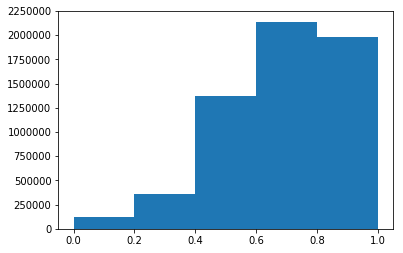

In [7]:
plt.hist(ratings['scaled_rating'],5)
plt.show()

In [8]:
train,test = train_test_split(ratings,test_size=0.2)
train.shape

(4781183, 4)

In [9]:
train_books = np.array(train['book_id'])
train_users = np.array(train['user_id'])
train_ratings = np.array(train['scaled_rating'])

In [10]:
train_books,train_users,train_ratings = shuffle([train_books,train_users,train_ratings])

### Define explicit Matrix Factorization model with Keras

In [49]:
nr_books = max(ratings['book_id'])
nr_books

10000

In [50]:
nr_users = max(ratings['user_id'])
nr_users

53424

In [51]:
EMBEDDING_DIM = 50

In [52]:
user_input = Input(shape=(1,),dtype='int32', name="UserInput")

In [53]:
user_embedding = Embedding(input_dim=nr_users+1,
                               output_dim=EMBEDDING_DIM,
                               input_length=1,
                               trainable=True,
#                               embeddings_regularizer=regularizers.l2(0.0001),
                               name="UserEmbedding")(user_input)

In [54]:
user_embedding = Reshape(target_shape=(EMBEDDING_DIM,))(user_embedding)
user_embedding.shape

TensorShape([Dimension(None), Dimension(50)])

In [55]:
book_input = Input(shape=(1,),dtype='int32', name="BookInput")

In [56]:
book_embedding = Embedding(input_dim=nr_books+1,
                               output_dim=EMBEDDING_DIM,
                               input_length=1,
                               trainable=True,
#                               embeddings_regularizer=regularizers.l2(0.0001), 
                               name="BookEmbedding")(book_input)

In [57]:
book_embedding = Reshape(target_shape=(EMBEDDING_DIM,))(book_embedding)
book_embedding.shape

TensorShape([Dimension(None), Dimension(50)])

In [58]:
dot_prod = Dot(axes=1,normalize=False)([book_embedding,user_embedding])
dot_prod.shape

TensorShape([Dimension(None), Dimension(1)])

In [59]:
embedding_model0 = Model(inputs=[book_input,user_input], outputs=[dot_prod])

In [60]:
embedding_model0.compile(loss='mse'
                         , optimizer='adam'
                         ,metrics=['mean_squared_error','mean_absolute_error'])

In [61]:
embedding_model0.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
BookInput (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
UserInput (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
BookEmbedding (Embedding)       (None, 1, 50)        500050      BookInput[0][0]                  
__________________________________________________________________________________________________
UserEmbedding (Embedding)       (None, 1, 50)        2671250     UserInput[0][0]                  
__________________________________________________________________________________________________
reshape_6 

### Train model

In [62]:
import time
from keras.callbacks import ModelCheckpoint
save_path = "./models"
mytime = time.strftime("%Y_%m_%d_%H_%M")
modname = 'explicit_mf_50' + mytime 
thename = save_path + '/' + modname + '.h5'
mcheck = ModelCheckpoint(thename , monitor='val_loss', save_best_only=True)

In [63]:
model0_hist = embedding_model0.fit([train['book_id'],train['user_id']], train['scaled_rating'],
    epochs=3, 
    batch_size=256,
    validation_data=([test['book_id'],test['user_id']], test['scaled_rating']),
    callbacks=[mcheck]
)

Train on 4781183 samples, validate on 1195296 samples
Epoch 1/3
4781183/4781183 [==============================] - 891s 186us/step - loss: 0.1159 - mean_squared_error: 0.1159 - mean_absolute_error: 0.2495 - val_loss: 0.0514 - val_mean_squared_error: 0.0514 - val_mean_absolute_error: 0.1773
Epoch 2/3
4781183/4781183 [==============================] - 891s 186us/step - loss: 0.0446 - mean_squared_error: 0.0446 - mean_absolute_error: 0.1643 - val_loss: 0.0498 - val_mean_squared_error: 0.0498 - val_mean_absolute_error: 0.1735
Epoch 3/3
4781183/4781183 [==============================] - 965s 202us/step - loss: 0.0370 - mean_squared_error: 0.0370 - mean_absolute_error: 0.1488 - val_loss: 0.0517 - val_mean_squared_error: 0.0517 - val_mean_absolute_error: 0.1760


In [ ]:
# Train on 597647 samples, validate on 5378832 samples
# Epoch 1/1
# 597647/597647 [==============================] - 245s - loss: 0.6358 - mean_squared_error: 0.5943 - val_loss: 0.6350 - val_mean_squared_error: 0.5942

In [64]:
model0_hist

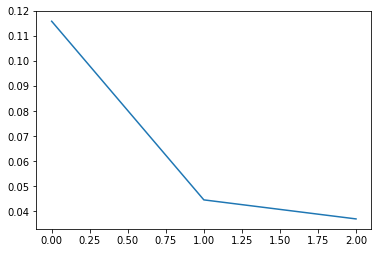

In [70]:
plt.plot(model0_hist.history['loss'])

In [65]:
embedding_model0.save('models/explicit_mf_keras_50dim')

### Check model predictions

In [66]:
test_predict = embedding_model0.predict([test['book_id'],test['user_id']])
#embedding_model0.predict([test['book_id'][110:120],test['user_id'][110:120]])

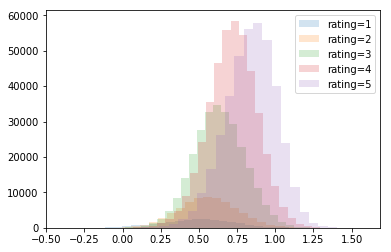

In [82]:
plt.hist(test_predict[test['rating']==1],30,label="rating=1",alpha=0.2)
plt.hist(test_predict[test['rating']==2],30,label="rating=2",alpha=0.2)
plt.hist(test_predict[test['rating']==3],30,label="rating=3",alpha=0.2)
plt.hist(test_predict[test['rating']==4],30,label="rating=4",alpha=0.2)
plt.hist(test_predict[test['rating']==5],30,label="rating=5",alpha=0.2)
plt.legend()
plt.show()

### Examine book embeddings

In [71]:
book_vectors = embedding_model0.layers[2].get_weights()[0]

In [92]:
np.save('models/mf_book_vectors.npy',book_vectors)

In [72]:
def cosine_sim(a,b):
    return dot(a,b) / (norm(a)*norm(b))

In [73]:
books = pd.read_csv('goodbooks-10k-master/books.csv')
books.head(30)

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...
5,6,11870085,11870085,16827462,226,525478817,9.780525e+12,John Green,2012.0,The Fault in Our Stars,...,2346404,2478609,140739,47994,92723,327550,698471,1311871,https://images.gr-assets.com/books/1360206420m...,https://images.gr-assets.com/books/1360206420s...
6,7,5907,5907,1540236,969,618260307,9.780618e+12,J.R.R. Tolkien,1937.0,The Hobbit or There and Back Again,...,2071616,2196809,37653,46023,76784,288649,665635,1119718,https://images.gr-assets.com/books/1372847500m...,https://images.gr-assets.com/books/1372847500s...
7,8,5107,5107,3036731,360,316769177,9.780317e+12,J.D. Salinger,1951.0,The Catcher in the Rye,...,2044241,2120637,44920,109383,185520,455042,661516,709176,https://images.gr-assets.com/books/1398034300m...,https://images.gr-assets.com/books/1398034300s...
8,9,960,960,3338963,311,1416524797,9.781417e+12,Dan Brown,2000.0,Angels & Demons,...,2001311,2078754,25112,77841,145740,458429,716569,680175,https://images.gr-assets.com/books/1303390735m...,https://images.gr-assets.com/books/1303390735s...
9,10,1885,1885,3060926,3455,679783261,9.780680e+12,Jane Austen,1813.0,Pride and Prejudice,...,2035490,2191465,49152,54700,86485,284852,609755,1155673,https://images.gr-assets.com/books/1320399351m...,https://images.gr-assets.com/books/1320399351s...


In [74]:
book_vectors[1]

array([-0.11418781,  0.03237452, -0.09745414,  0.22580427, -0.05947193,
       -0.01271509,  0.02558159,  0.09900066,  0.13317715,  0.07843966,
        0.07551242,  0.1547276 ,  0.02412163,  0.17634785, -0.04864031,
       -0.14394015,  0.21433015, -0.08434381,  0.09133121, -0.09055829,
        0.04147782, -0.17673947,  0.18880348, -0.10982049,  0.07107463,
       -0.06382209, -0.24918886, -0.12466851, -0.16878393, -0.20764002,
        0.30093053, -0.07783522, -0.08971309, -0.22646411, -0.23340195,
        0.30912971,  0.08318889,  0.02772594, -0.15216407, -0.14932548,
       -0.52286655,  0.1789505 ,  0.07844093,  0.01124645,  0.01917026,
       -0.08447771, -0.02698627, -0.15111247, -0.16096362,  0.06417839],
      dtype=float32)

In [75]:
# Hunger Games vs. Catching Fire
cosine_sim(book_vectors[1],book_vectors[17])

0.94914025

In [76]:
# Harry potter #2 vs. Harry potter #3
cosine_sim(book_vectors[22],book_vectors[17])

0.5469519

In [86]:
cosine_sim(book_vectors[34],book_vectors[7])

0.24707398

In [ ]:
def similar_books(book_id,book_dict,nr_recs=10):
    vec_i = book_dict[book_id]['tag_vector']
    recs_list = []
    for rec_id,rec_dict in book_dict.items():
        if rec_id != book_id:
            rec_vec = book_dict[rec_id]['tag_vector']
            sim_ij = cosine_sim(vec_i,rec_vec)
            recs_list.append((rec_id
                              ,book_dict[rec_id]['book_title']
                              ,book_dict[rec_id]['authors']
                              ,sim_ij))
    recs_list.sort(key=itemgetter(3),reverse=True)
    return recs_list[:nr_recs]


numpy.ndarray

In [89]:
book_vectors[0]

array([ 0.02191124,  0.00031251,  0.02951003, -0.0022561 ,  0.04848644,
       -0.01351795, -0.02550118,  0.03073582, -0.00096082, -0.01759486,
       -0.03895646,  0.02693613,  0.04113272,  0.0169766 ,  0.03007608,
        0.03003671,  0.03501724,  0.00593572,  0.00429562, -0.01825724,
       -0.01363432, -0.04738292,  0.00636296,  0.04361651, -0.04780853,
        0.02841511, -0.02854743, -0.01028212,  0.04357059,  0.04920341,
        0.02648291, -0.0339924 ,  0.01854458,  0.03787554,  0.00708349,
        0.03737992, -0.0266271 ,  0.01179857, -0.00340716,  0.04267389,
       -0.00982506, -0.04695057, -0.01692627, -0.01525564, -0.04473796,
       -0.01004294, -0.03895345, -0.00761893, -0.04410977, -0.04286149],
      dtype=float32)